#Install Dependencies

In [48]:
!pip install tensorflow opencv-python-headless matplotlib

In [49]:
import sys
print(sys.executable)

/Users/gabrielschull/anaconda3/envs/facialrecognition/bin/python


In [50]:
#import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt


In [51]:
#import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [52]:
#Set GPU Memory Consumption Growth to avoid OOM errors -> wrong tensorflow version for this, not necessary though
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [53]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [54]:
#Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [55]:
#Make dirs
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

In [56]:
#Collecting labelled faces in the wild dataset at http://vis-www.cs.umass.edu/lfw/ (as gzipped tar file)

In [57]:
#uncompress Tar Labelled Faces in the Wild dataser
#!tar -xf lfw.tar

In [58]:
# Move lfw imgs to the following repo data/negative
#for directory in os.listdir('lfw'):
   # for file in os.listdir(os.path.join('lfw', directory)):
       # EX_PATH = os.path.join('lfw', directory, file)
       # NEW_PATH = os.path.join(NEG_PATH, file)
       # os.replace(EX_PATH, NEW_PATH)
    

In [59]:
import uuid

In [60]:
#Collect positive and anchor classes

cap = cv2.VideoCapture(0) #Establish a connection to the webcam
while cap.isOpened():
    ret, frame = cap.read() 
    
    #cut down to 250x250px frame
    frame = frame[250:250+250,475:475+250,:]

    key = cv2.waitKey(1) & 0XFF

    #collect anchors
    if key == ord('a'):
        #create unique filepath
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)
        break

    #collect positives
    if key == ord('p'):
        #create unique filepath
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out positive image
        cv2.imwrite(imgname, frame)
        break
        
        
    #show image back to screen
    cv2.imshow('Image Collection', frame)

    #breaking if q hit on keyboard after 1 ms
    if key == ord('q'):
        break
#release webcam & close the image show frame
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

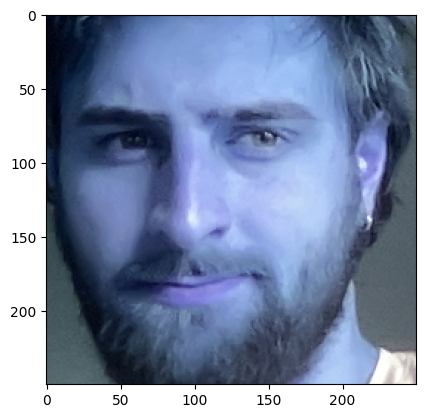

In [61]:
plt.imshow(frame)

In [62]:
#Load and preprocess Images
# get image directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [90]:
dir_test = anchor.as_numpy_iterator()

In [91]:
print(dir_test.next())

b'data/anchor/9c95ea6e-d2a2-11ee-aa4a-563466da705a.jpg'


In [92]:
#Preprocessing - scale and resize

def preprocess(file_path):

    # read in image from file path
    byte_img = tf.io.read_file(file_path)
    # load in the image
    img = tf.io.decode_jpeg(byte_img)
    # preprocessing steps - resize image to be 105x105x3
    img = tf.image.resize(img, (105,105))
    # scale image to be between 0 and 1
    img = img / 255.0

    
    return img

In [93]:
img = preprocess('data/anchor/8de3e8e0-d2a2-11ee-aa4a-563466da705a.jpg')

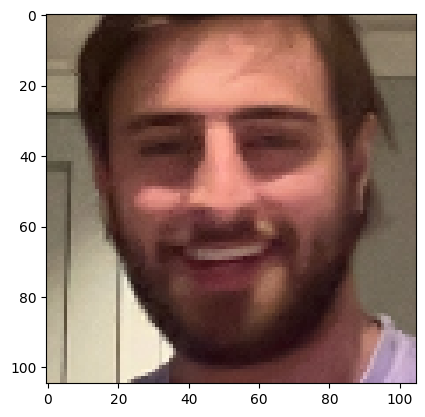

In [94]:
plt.imshow(img)

In [95]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [ ]:
# Create labelled dataset
# (anchor, positive) =>  1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [127]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [128]:
samples = data.as_numpy_iterator()

In [129]:
example = samples.next()

In [130]:
example

(b'data/anchor/ceb8176a-d2a2-11ee-944e-563466da705a.jpg',
 b'data/positive/03db2c98-d2a3-11ee-ab5a-563466da705a.jpg',
 1.0)

In [131]:
# Build Train and Test Partition
def preprocess_twin(input_img, validation_img, label):
     return (preprocess(input_img), preprocess(validation_img), label)

In [132]:
preprocess_twin(*example)

(<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
 array([[[0.5409075 , 0.48208398, 0.399731  ],
         [0.53265977, 0.47383624, 0.39148328],
         [0.54680103, 0.48797745, 0.4056245 ],
         ...,
         [0.5410231 , 0.48219958, 0.40768978],
         [0.5493531 , 0.49052963, 0.4160198 ],
         [0.5393069 , 0.48048335, 0.40597355]],
 
        [[0.5461185 , 0.48729497, 0.404942  ],
         [0.5689276 , 0.51010406, 0.42775112],
         [0.55683607, 0.49801254, 0.4156596 ],
         ...,
         [0.5492131 , 0.49038953, 0.41587973],
         [0.5526611 , 0.49383757, 0.41932777],
         [0.53324   , 0.47441646, 0.39990664]],
 
        [[0.55339694, 0.4945734 , 0.41222045],
         [0.5489263 , 0.49010274, 0.40774977],
         [0.5616069 , 0.50278336, 0.42043042],
         ...,
         [0.5540817 , 0.4952581 , 0.4207483 ],
         [0.5415166 , 0.4826931 , 0.40818328],
         [0.55415505, 0.4953315 , 0.4208217 ]],
 
        ...,
 
        [[0.77159315, 0.74806374

In [133]:
# Build dataLoader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [134]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [135]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [136]:
train_samples = train_data.as_numpy_iterator()

In [137]:
train_sample = train_samples.next()

In [138]:
len(train_sample[0])

16

In [139]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
# Build embedding layer